**Training Deep Neural Nets**

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Vanishing/Exploding Gradients Problem

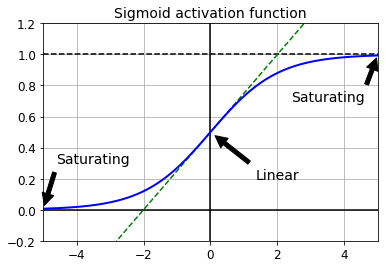

In [2]:
# Logit / Sigmoid function plot

def logit(z):
    return 1 / (1 + np.exp(-z))


z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.show()

## He Initialization

In [3]:
import tensorflow as tf

reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

he_init = tf.contrib.layers.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

W0528 14:09:32.421201 140176127121216 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0528 14:09:32.422976 140176127121216 deprecation.py:323] From <ipython-input-3-907ac0d9b621>:12: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


## Nonsaturating Activation Functions

### Leaky ReLU

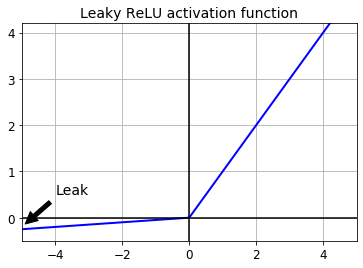

In [4]:
# Leaky ReLU plot 

def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

In [5]:
# Implementing Leaky ReLU in TensorFlow

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

W0528 14:09:33.046187 140176127121216 deprecation.py:506] From /usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Let's train a neural network on MNIST using the Leaky ReLU

### Step 1- First let's create the graph

In [6]:
x = leaky_relu(3)
y = tf.nn.relu(3)
with tf.Session() as s:
    print(x.eval())
    print(y.eval())

3.0
3


In [7]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 100
n_hidden2 = 100
n_outputs = 10

In [8]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [9]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [10]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [11]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

W0528 14:09:33.310326 140176127121216 deprecation.py:323] From /usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [13]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### Step 2- Now let's load the data

In [14]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/")

W0528 14:09:33.426896 140176127121216 deprecation.py:323] From <ipython-input-14-78e19e1f4ee4>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0528 14:09:33.427720 140176127121216 deprecation.py:323] From /usr/local/anaconda/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0528 14:09:33.428557 140176127121216 deprecation.py:323] From /usr/local/anaconda/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future v

Extracting data/train-images-idx3-ubyte.gz


W0528 14:09:33.708528 140176127121216 deprecation.py:323] From /usr/local/anaconda/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0528 14:09:33.760303 140176127121216 deprecation.py:323] From /usr/local/anaconda/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [15]:
n_epochs = 10
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_test = accuracy.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
            print(epoch, "Batch accuracy:", acc_train, "Validation accuracy:", acc_test)
    w = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0").eval()
    print(w)
    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")

0 Batch accuracy: 0.88 Validation accuracy: 0.8948
5 Batch accuracy: 0.92 Validation accuracy: 0.9448
[[-0.07806651 -0.01079746 -0.03841371 ... -0.04480319  0.02122388
   0.0709946 ]
 [ 0.06750461  0.04689544  0.07546921 ...  0.06788346 -0.06883337
  -0.03172435]
 [-0.0721751   0.01650167 -0.04934056 ...  0.01564056 -0.03459637
  -0.06437095]
 ...
 [ 0.06046264  0.00849035  0.07129607 ...  0.05243374 -0.05161098
   0.01578974]
 [ 0.01687084  0.06047095 -0.04000824 ... -0.02498557  0.04501233
   0.07985909]
 [ 0.0578775  -0.02920518 -0.07532586 ... -0.03761901  0.07425359
   0.06416787]]


In [16]:
g = tf.get_default_graph()
g.get_operations()

[<tf.Operation 'X' type=Placeholder>,
 <tf.Operation 'y' type=Placeholder>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/shape' type=Const>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/min' type=Const>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/max' type=Const>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/RandomUniform' type=RandomUniform>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/sub' type=Sub>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/mul' type=Mul>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform' type=Add>,
 <tf.Operation 'hidden1/kernel' type=VariableV2>,
 <tf.Operation 'hidden1/kernel/Assign' type=Assign>,
 <tf.Operation 'hidden1/kernel/read' type=Identity>,
 <tf.Operation 'hidden1/bias/Initializer/zeros' type=Const>,
 <tf.Operation 'hidden1/bias' type=VariableV2>,
 <tf.Operation 'hidden1/bias/Assign' type=Assign>,
 <tf.Operation 'hidden1/bias/read' type=Identity>,
 <tf.Operation 

### ELU

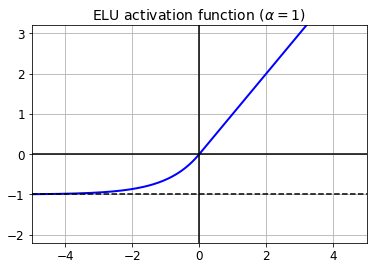

In [17]:
# ELU plot

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

In [18]:
v = -13.0
with tf.Session() as s:
    print(tf.nn.elu([v]).eval())
print(elu(v))

[-0.99999774]
-0.999997739670593


In [19]:
# Implementing ELU in TensorFlow
# Just specify the activation function when building each layer
    
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

### SELU Activation Function

In [20]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

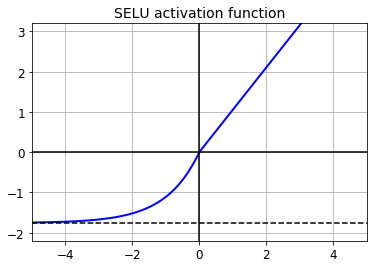

In [21]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

In [22]:
print(r"sandeep \t giri \n sss")

sandeep \t giri \n sss


In [23]:
print("sandeep \t giri \n sss")

sandeep 	 giri 
 sss


In [24]:
x = [1,1,1]
sd = np.std(x, axis=0)
mean = np.mean(x, axis=0)

(x - mean) / sd

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


array([nan, nan, nan])

In [25]:
# Check the mean and standard deviation in the deep layers for SELU activation function

np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("Layer {}: {:.2f} < mean < {:.2f}, {:.2f} < std deviation < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

Layer 0: -0.26 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 10: -0.24 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 20: -0.17 < mean < 0.18, 0.74 < std deviation < 1.24
Layer 30: -0.27 < mean < 0.24, 0.78 < std deviation < 1.20
Layer 40: -0.38 < mean < 0.39, 0.74 < std deviation < 1.25
Layer 50: -0.27 < mean < 0.31, 0.73 < std deviation < 1.27
Layer 60: -0.26 < mean < 0.43, 0.74 < std deviation < 1.35
Layer 70: -0.19 < mean < 0.21, 0.75 < std deviation < 1.21
Layer 80: -0.18 < mean < 0.16, 0.72 < std deviation < 1.19
Layer 90: -0.19 < mean < 0.16, 0.75 < std deviation < 1.20


In [26]:
r"Sandeep"

'Sandeep'

### Let's create a neural net for MNIST using the SELU activation function

In [27]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [28]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    # dimension of logits - batch_size x 10
    # dims of y - [batch_size]
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    # logits[0] = [300, 20, 1, .3, .5, .07, .03, .01, .06]
    # actual[0] = [1, 0,0,0,0,0,0,0,0,0]
    # y[0] = 0
    # correct[0] = True
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

In [29]:
with tf.Session() as sess:
    print(tf.nn.in_top_k([[10, 2, 0.5], [10, 2, 0.5]], [2, 1], 2).eval())

[False  True]


Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [30]:
means = mnist.train.images.mean(axis=0, keepdims=True)
stds = mnist.train.images.std(axis=0, keepdims=True) + 1e-10

training_errors = []
testing_erros = []
epochs = []
losses = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch_scaled = (X_batch - means) / stds
            training_op_result, loss_value = sess.run([training_op, loss], feed_dict={X: X_batch_scaled, y: y_batch})
            losses.append(loss_value)
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            X_val_scaled = (mnist.validation.images - means) / stds
            acc_test = accuracy.eval(feed_dict={X: X_val_scaled, y: mnist.validation.labels})
            training_errors.append(acc_train)
            testing_erros.append(acc_test)
            epochs.append(epoch)
            print(epoch, "Batch accuracy:", acc_train, "Validation accuracy:", acc_test)

    save_path = saver.save(sess, "model_ckps/my_model_final_selu.ckpt")

0 Batch accuracy: 0.92 Validation accuracy: 0.9194
5 Batch accuracy: 0.98 Validation accuracy: 0.9548
10 Batch accuracy: 1.0 Validation accuracy: 0.962
15 Batch accuracy: 1.0 Validation accuracy: 0.9684
20 Batch accuracy: 1.0 Validation accuracy: 0.9688
25 Batch accuracy: 1.0 Validation accuracy: 0.9696
30 Batch accuracy: 1.0 Validation accuracy: 0.9704
35 Batch accuracy: 1.0 Validation accuracy: 0.9716


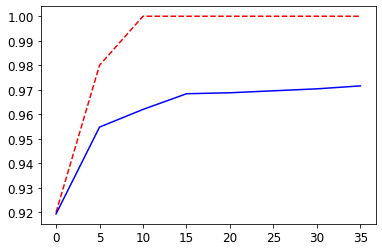

In [31]:
import matplotlib.pyplot as plt

# red dashes, blue squares and green triangles
plt.plot(epochs, training_errors, 'r--', epochs, testing_erros, 'b-')
plt.show()


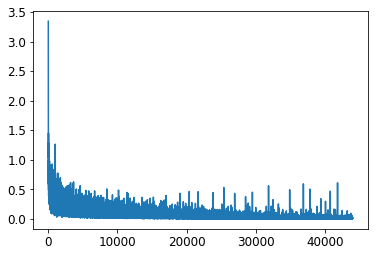

In [32]:
plt.plot(losses)

# Batch Normalization

In [33]:
# Let's implement Batch Normalization with TensorFlow

reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

# Set Training. Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder)
# Whether to return the output in training mode (normalized with statistics of the current batch) 
# or in inference mode (normalized with moving statistics)

training = tf.placeholder_with_default(False, shape=(), name='training')


hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")

# We will discuss momentum later in the course

bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

W0528 14:11:34.805156 140176127121216 deprecation.py:323] From <ipython-input-33-9a50d1439796>:26: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


In [34]:
# In previous example, we passed parameters repeatedly to batch_normalization function
# To avoid repeating the same parameters over and over again, we can use Python's partial() function 
# Let's improve previous example with partial() 

from functools import partial


reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

In [35]:
# Now let's build a neural net for MNIST
# Using the ELU activation function and Batch Normalization at each layer

reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.contrib.layers.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [36]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [37]:
# Execution phase

n_epochs = 100
batch_size = 200

# When is_training is True the moving_mean and moving_variance need to be updated by running these commands
# extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# sess.run([train_op, extra_update_ops], ...)

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")

0 Test accuracy: 0.8653
1 Test accuracy: 0.8939
2 Test accuracy: 0.9086
3 Test accuracy: 0.9199
4 Test accuracy: 0.9258
5 Test accuracy: 0.9328
6 Test accuracy: 0.9379
7 Test accuracy: 0.9429
8 Test accuracy: 0.9448
9 Test accuracy: 0.9478
10 Test accuracy: 0.9506
11 Test accuracy: 0.9532
12 Test accuracy: 0.9549
13 Test accuracy: 0.9576
14 Test accuracy: 0.9583
15 Test accuracy: 0.9595
16 Test accuracy: 0.96
17 Test accuracy: 0.9612
18 Test accuracy: 0.9622
19 Test accuracy: 0.9634
20 Test accuracy: 0.9644
21 Test accuracy: 0.9645
22 Test accuracy: 0.9655
23 Test accuracy: 0.9661
24 Test accuracy: 0.9669
25 Test accuracy: 0.9682
26 Test accuracy: 0.9678
27 Test accuracy: 0.9681
28 Test accuracy: 0.9689
29 Test accuracy: 0.9711
30 Test accuracy: 0.9699
31 Test accuracy: 0.9712
32 Test accuracy: 0.9699
33 Test accuracy: 0.9715
34 Test accuracy: 0.9713
35 Test accuracy: 0.971
36 Test accuracy: 0.9715
37 Test accuracy: 0.973
38 Test accuracy: 0.9731
39 Test accuracy: 0.9728
40 Test accura

What!? That's not a great accuracy for MNIST. Of course, if you train for longer it will get much better accuracy, but with such a shallow network, Batch Norm and ELU are unlikely to have very positive impact: they shine mostly for much deeper nets.

One more thing: notice that the list of trainable variables is shorter than the list of all global variables. This is because the moving averages are non-trainable variables. If you want to reuse a pretrained neural network (see below), you must not forget these non-trainable variables.

In [38]:
# List trainable variables

[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [39]:
# List global variables

[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

## Gradient Clipping

In [40]:
# Create a simple neural net for MNIST and add gradient clipping

reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [41]:
# Now we apply gradient clipping.
# For this, we need to get the gradients, use the `clip_by_value()` function to clip them, then apply them

learning_rate = 0.01

threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

The rest is the same as usual:

In [42]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 5
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")

0 Test accuracy: 0.3081
1 Test accuracy: 0.8013
2 Test accuracy: 0.8798
3 Test accuracy: 0.9039
4 Test accuracy: 0.9118


In [43]:
!ls -l model_ckps/my_model_final.ckpt*

-rw-r--r-- 1 rajtilakbhattacharjee7947 rajtilakbhattacharjee7947 1034840 May 28 14:14 model_ckps/my_model_final.ckpt.data-00000-of-00001
-rw-r--r-- 1 rajtilakbhattacharjee7947 rajtilakbhattacharjee7947     487 May 28 14:14 model_ckps/my_model_final.ckpt.index
-rw-r--r-- 1 rajtilakbhattacharjee7947 rajtilakbhattacharjee7947   55221 May 28 14:14 model_ckps/my_model_final.ckpt.meta


## Reusing Pretrained Layers

## Reusing a TensorFlow Model

In [44]:
reset_graph()
for op in tf.get_default_graph().get_operations():
    print(op.name)

In [45]:
tf.get_default_graph().get_operations()

[]

In [46]:
# Reusing a TensorFlow Model - Step 1

reset_graph()
saver = tf.train.import_meta_graph("model_ckps/my_model_final.ckpt.meta")

In [47]:
# Reusing a TensorFlow Model - Step 2
# List all the operations using below code

for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

In [48]:
# Reusing a TensorFlow Model - Step 3
# Once we know which operations do we need then
# we can get a handle on them using the graph's get_operation_by_name() or get_tensor_by_name() methods

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

In [49]:
graph = tf.get_default_graph()
graph

In [50]:
# Reusing a TensorFlow Model - Step 4
# Now you can start a session, restore the model's state and continue training on your data

with tf.Session() as sess:
    saver.restore(sess, "model_ckps/my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_new_model_final.ckpt")    

W0528 14:14:31.828473 140176127121216 deprecation.py:323] From /usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


0 Test accuracy: 0.9208
1 Test accuracy: 0.9247
2 Test accuracy: 0.9299
3 Test accuracy: 0.9356
4 Test accuracy: 0.9397


### Reusing only part of the original model

In [51]:
# In general, we restore only early layers
# Let's restore only hidden layers 1, 2 and 3

reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "model_ckps/my_model_final.ckpt")

    for epoch in range(n_epochs):                                     
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_new_model_final.ckpt")

0 Test accuracy: 0.909
1 Test accuracy: 0.9146
2 Test accuracy: 0.9181
3 Test accuracy: 0.9274
4 Test accuracy: 0.9281


In [52]:
#tf.get
tf.get_default_graph()

## Reusing Models from Other Frameworks

In this example, for each variable we want to reuse, we find its initializer's assignment operation, and we get its second input, which corresponds to the initialization value. When we run the initializer, we replace the initialization values with the ones we want, using a `feed_dict`:

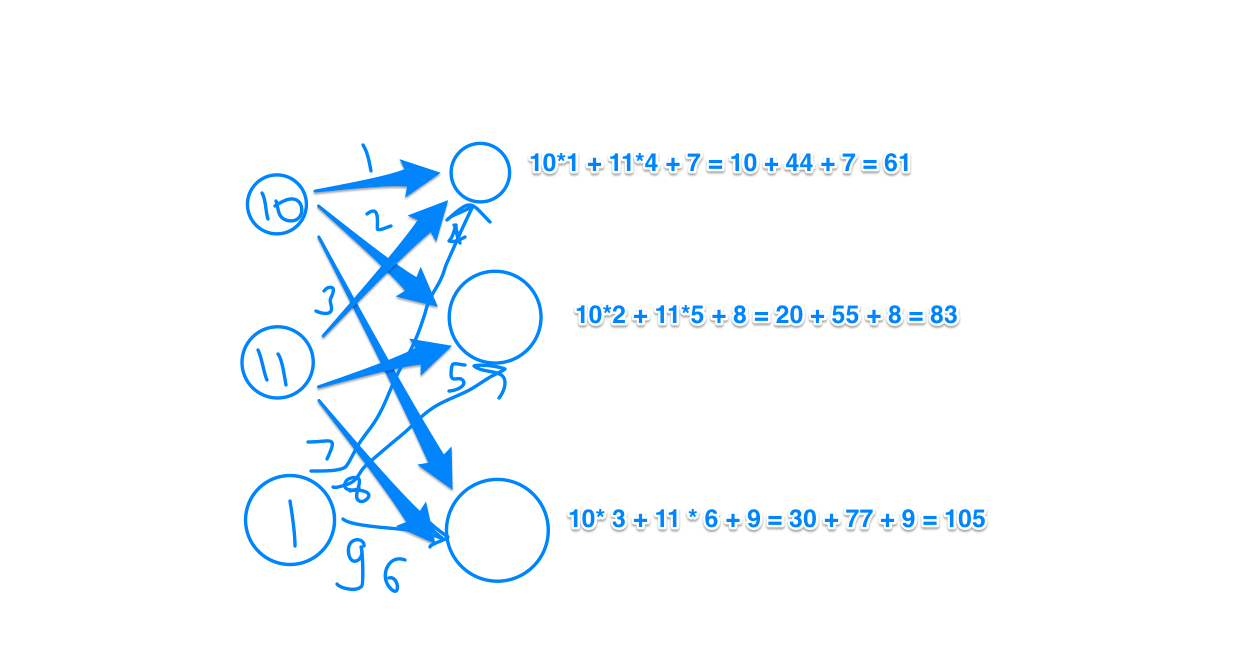

In [53]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


In [54]:
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
for u in assign_kernel.inputs:
    print(u)

Tensor("hidden1/kernel:0", shape=(2, 3), dtype=float32_ref)
Tensor("hidden1/kernel/Initializer/random_uniform:0", shape=(2, 3), dtype=float32)


# Faster Optimizers

## Momentum optimization

## TODO: Write the import and other variables needed

In [55]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [56]:
learning_rate = 0.001

In [57]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

## Nesterov Accelerated Gradient

In [58]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

## AdaGrad

In [59]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

## RMSProp

In [60]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

## Adam Optimization

In [61]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Learning Rate Scheduling

In [62]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [63]:
with tf.name_scope("train"):       # not shown in the book
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [64]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [65]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")

0 Test accuracy: 0.9513
1 Test accuracy: 0.9626
2 Test accuracy: 0.9739
3 Test accuracy: 0.979
4 Test accuracy: 0.9809
5 Test accuracy: 0.9829
6 Test accuracy: 0.9822
7 Test accuracy: 0.9834
8 Test accuracy: 0.9824
9 Test accuracy: 0.9836
10 Test accuracy: 0.9832
11 Test accuracy: 0.9832
12 Test accuracy: 0.9834
13 Test accuracy: 0.9832
14 Test accuracy: 0.9834
15 Test accuracy: 0.9833
16 Test accuracy: 0.9833
17 Test accuracy: 0.9834
18 Test accuracy: 0.9834
19 Test accuracy: 0.9834


## Using Adam

In [66]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [67]:
with tf.name_scope("train"):       # not shown in the book
    learning_rate = 0.01
    optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

W0528 14:15:33.866211 140176127121216 deprecation.py:506] From /usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/training/adagrad.py:76: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [68]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [69]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")

0 Test accuracy: 0.9276
1 Test accuracy: 0.9452
2 Test accuracy: 0.9545
3 Test accuracy: 0.9588
4 Test accuracy: 0.9633
5 Test accuracy: 0.9659
6 Test accuracy: 0.9683
7 Test accuracy: 0.97
8 Test accuracy: 0.9713
9 Test accuracy: 0.9721
10 Test accuracy: 0.9748
11 Test accuracy: 0.9742
12 Test accuracy: 0.9758
13 Test accuracy: 0.9758
14 Test accuracy: 0.9762
15 Test accuracy: 0.9773
16 Test accuracy: 0.977
17 Test accuracy: 0.9767
18 Test accuracy: 0.978
19 Test accuracy: 0.9781


# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

Let's implement $\ell_1$ regularization manually. First, we create the model, as usual (with just one hidden layer this time, for simplicity):

In [70]:
# Let's implement ℓ1 regularization manually.
# Assuming we have just one hidden layer

reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

Next, we get a handle on the layer weights, and we compute the total loss, which is equal to the sum of the usual cross entropy loss and the $\ell_1$ loss (i.e., the absolute values of the weights):

In [71]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 regularization hyperparameter

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

The rest is just as usual:

In [72]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [73]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")

0 Test accuracy: 0.8362
1 Test accuracy: 0.8706
2 Test accuracy: 0.8813
3 Test accuracy: 0.8915
4 Test accuracy: 0.8955
5 Test accuracy: 0.8988
6 Test accuracy: 0.9012
7 Test accuracy: 0.9026
8 Test accuracy: 0.9041
9 Test accuracy: 0.9057
10 Test accuracy: 0.9052
11 Test accuracy: 0.906
12 Test accuracy: 0.9066
13 Test accuracy: 0.9079
14 Test accuracy: 0.9073
15 Test accuracy: 0.908
16 Test accuracy: 0.9066
17 Test accuracy: 0.9064
18 Test accuracy: 0.9064
19 Test accuracy: 0.9065


### Go back to notebook

### Applying ℓ1 regularization in the network having two hidden layers

Alternatively, we can pass a regularization function to the `tf.layers.dense()` function, which will use it to create operations that will compute the regularization loss, and it adds these operations to the collection of regularization losses. The beginning is the same as above:

In [74]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

Next, we will use Python's `partial()` function to avoid repeating the same arguments over and over again. Note that we set the `kernel_regularizer` argument:

In [75]:
from functools import partial
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l2_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")

Next we must add the regularization losses to the base loss:

In [76]:
with tf.name_scope("loss"):                                     
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=y, logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

And the rest is the same as usual:

In [77]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [78]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")

0 Test accuracy: 0.81
1 Test accuracy: 0.8712
2 Test accuracy: 0.8889
3 Test accuracy: 0.8993
4 Test accuracy: 0.9077
5 Test accuracy: 0.9106
6 Test accuracy: 0.9156
7 Test accuracy: 0.9187
8 Test accuracy: 0.9221
9 Test accuracy: 0.9265
10 Test accuracy: 0.9274
11 Test accuracy: 0.9287
12 Test accuracy: 0.9311
13 Test accuracy: 0.9321
14 Test accuracy: 0.9351
15 Test accuracy: 0.9367
16 Test accuracy: 0.9388
17 Test accuracy: 0.9395
18 Test accuracy: 0.9402
19 Test accuracy: 0.9419


## Dropout

In [79]:
# Apply dropout regularization to three-layer neural network

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [80]:
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5

# Apply dropout to input layer 
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    
    # Apply dropout to the first hidden layer
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    
    # Apply dropout to the second hidden layer
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

W0528 14:17:05.056882 140176127121216 deprecation.py:323] From <ipython-input-80-b6038319c9c9>:6: dropout (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dropout instead.


In [81]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [82]:
n_epochs = 200
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")

0 Test accuracy: 0.9203
1 Test accuracy: 0.9417
2 Test accuracy: 0.9498
3 Test accuracy: 0.9521
4 Test accuracy: 0.956
5 Test accuracy: 0.9579
6 Test accuracy: 0.9579
7 Test accuracy: 0.9628
8 Test accuracy: 0.9636
9 Test accuracy: 0.9631
10 Test accuracy: 0.9628
11 Test accuracy: 0.9645
12 Test accuracy: 0.9652
13 Test accuracy: 0.967
14 Test accuracy: 0.9677
15 Test accuracy: 0.9699
16 Test accuracy: 0.9693
17 Test accuracy: 0.9692
18 Test accuracy: 0.9702
19 Test accuracy: 0.9716
20 Test accuracy: 0.9693
21 Test accuracy: 0.9694
22 Test accuracy: 0.9709
23 Test accuracy: 0.9704
24 Test accuracy: 0.9724
25 Test accuracy: 0.972
26 Test accuracy: 0.9722
27 Test accuracy: 0.973
28 Test accuracy: 0.9702
29 Test accuracy: 0.97
30 Test accuracy: 0.9718
31 Test accuracy: 0.9716
32 Test accuracy: 0.9712
33 Test accuracy: 0.9726
34 Test accuracy: 0.9717
35 Test accuracy: 0.9722
36 Test accuracy: 0.9725
37 Test accuracy: 0.9733
38 Test accuracy: 0.9711
39 Test accuracy: 0.9721
40 Test accuracy

## Max norm

Let's go back to a plain and simple neural net for MNIST with just 2 hidden layers:

In [83]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Next, let's get a handle on the first hidden layer's weight and create an operation that will compute the clipped weights using the `clip_by_norm()` function. Then we create an assignment operation to assign the clipped weights to the weights variable:

In [84]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

We can do this as well for the second hidden layer:

In [85]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

Let's add an initializer and a saver:

In [86]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

And now we can train the model. It's pretty much as usual, except that right after running the `training_op`, we run the `clip_weights` and `clip_weights2` operations:

In [87]:
n_epochs = 20
batch_size = 50

In [88]:
with tf.Session() as sess:                                              # not shown in the book
    init.run()                                                          # not shown
    for epoch in range(n_epochs):                                       # not shown
        for iteration in range(mnist.train.num_examples // batch_size):  # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)       # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        # not shown
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images,       # not shown
                                            y: mnist.test.labels})      # not shown
        print(epoch, "Test accuracy:", acc_test)                        # not shown

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")               # not shown

0 Test accuracy: 0.9544
1 Test accuracy: 0.9657
2 Test accuracy: 0.9741
3 Test accuracy: 0.9716
4 Test accuracy: 0.9766
5 Test accuracy: 0.9765
6 Test accuracy: 0.9774
7 Test accuracy: 0.9788
8 Test accuracy: 0.9811
9 Test accuracy: 0.9806
10 Test accuracy: 0.9815
11 Test accuracy: 0.9801
12 Test accuracy: 0.9812
13 Test accuracy: 0.9816
14 Test accuracy: 0.9811
15 Test accuracy: 0.9824
16 Test accuracy: 0.9827
17 Test accuracy: 0.9826
18 Test accuracy: 0.9827
19 Test accuracy: 0.9825


The implementation above is straightforward and it works fine, but it is a bit messy. A better approach is to define a `max_norm_regularizer()` function:

In [89]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

Then you can call this function to get a max norm regularizer (with the threshold you want). When you create a hidden layer, you can pass this regularizer to the `kernel_regularizer` argument:

In [90]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [91]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [92]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Training is as usual, except you must run the weights clipping operations after each training operation:

In [93]:
n_epochs = 20
batch_size = 50

In [94]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images,     # not shown in the book
                                            y: mnist.test.labels})    # not shown
        print(epoch, "Test accuracy:", acc_test)                      # not shown

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")             # not shown

0 Test accuracy: 0.9515
1 Test accuracy: 0.9686
2 Test accuracy: 0.9727
3 Test accuracy: 0.9775
4 Test accuracy: 0.9766
5 Test accuracy: 0.9776
6 Test accuracy: 0.9787
7 Test accuracy: 0.9785
8 Test accuracy: 0.9809
9 Test accuracy: 0.98
10 Test accuracy: 0.9814
11 Test accuracy: 0.981
12 Test accuracy: 0.9806
13 Test accuracy: 0.981
14 Test accuracy: 0.9823
15 Test accuracy: 0.9814
16 Test accuracy: 0.9833
17 Test accuracy: 0.9831
18 Test accuracy: 0.9833
19 Test accuracy: 0.9834


## Dummy Example of Standard Normalization

In [95]:
import numpy as np
x = np.array([0.1, 0.01, 1,100, 200, 400, 50000, 100000])
mean = np.sum(x)/len(x)

In [96]:
mean

18837.63875

In [97]:
d = x - mean
ssq = np.sum(d*d)/len(x)

In [98]:
d

array([-18837.53875, -18837.62875, -18836.63875, -18737.63875,
       -18637.63875, -18437.63875,  31162.36125,  81162.36125])

In [99]:
d/np.sqrt(ssq)

array([-0.5420634 , -0.54206599, -0.54203751, -0.53918871, -0.53631114,
       -0.530556  ,  0.89671883,  2.33550394])

## Dummy Example of Clipping

In [100]:

a = [(3.4, "x"), (1.8, "y"), (-2.9, "z"), (-3.1, "zz")]

In [101]:
def clip_by_value(x, th):
    if x < -th:
        return -th;
    if x> th:
        return th
    return x

In [102]:
b = []
th = 3
for (k, v) in a:
    b.append((clip_by_value(k, th), v))
b

[(3, 'x'), (1.8, 'y'), (-2.9, 'z'), (-3, 'zz')]

In [103]:
th = 3
[(clip_by_value(k, th), v) for (k, v) in a]

[(3, 'x'), (1.8, 'y'), (-2.9, 'z'), (-3, 'zz')]

## Partial Function

In [104]:
from functools import partial
def multiply(x, y):
    return x*y
multiplyByTwo = partial(multiply, 2)

def multiplyByTwo_1(x):
    return multiply(x, 2)

In [105]:
multiplyByTwo(4)

8

In [106]:
multiplyByTwo_1(4)

8